# Compact Convolutional Transformer (CCT)

In [1]:
import sys
sys.dont_write_bytecode = True

import os
import tensorflow as tf

from evaluate.F1ScoreMetric import F1ScoreMetric as f1
from module.DatasetProcessor import DatasetProcessor
from script.plot_training_history import plot_training_history

In [2]:
# Display version of TensorFlow and Python
print(f"TensorFlow version: {tf.__version__}")
print(f"Python version: {sys.version}")

# Display Version of Nvidia Driver and CUDA
!nvidia-smi

TensorFlow version: 2.6.0
Python version: 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Tue Sep 19 17:38:18 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0              20W /  80W |    257MiB /  6144MiB |      6%      Default |
|                                         |     

## Configuration

In [3]:
CFG = {
    "fp16": False, # Use mixed precision training (True/False)
    "dataset_dir": ".\DATASET\ILLUST VS MANGA", 
    "image_size": 224,
    "conv_layer": [64, 128, 256], # 112, 56, 28,
    "num_head": 4,
    "latent_size": 256,
    "trans_layer": 7,
    "mlp_size": 512,
    "pos_embed": False,

    "batch": 16, # Batch size
    "optimizer1": tf.keras.optimizers.Adam(learning_rate=1e-4), # main training
    "optimizer2": tf.keras.optimizers.Adam(learning_rate=1e-6, decay=1e-4), # fine-tuning
    "loss_func": tf.losses.CategoricalCrossentropy(), # Loss function (Categorical Cross-Entropy)
}

## Initializing

In [4]:
if CFG["fp16"]:
    print("Activating mixed precision float16 ... ")
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Avoid out of memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Declare functions

In [5]:
def Custom_ImageDataGenerator(image_path, label, image_size):
    # Read the image file from the given path
    image = tf.io.read_file(image_path)
    
    # Decode the image into a tensor, disabling animation expansion
    image = tf.image.decode_image(image, expand_animations=False)
    
    # Resize the image to the specified dimensions while preserving aspect ratio and using antialiasing
    image = tf.image.resize(image, (image_size, image_size),
                            preserve_aspect_ratio=True,
                            antialias=True)
    
    # Resize the image with padding to ensure it has the exact dimensions specified
    image = tf.image.resize_with_pad(image, image_size, image_size)
    
    # Normalize the image pixel values to the range [0, 1] by dividing by 255.0
    image = image / 255.0
    
    return image, label

In [6]:
def raw_data_processing(data_list, dict_class, image_size):
    # Extract the image file paths from the data_list
    path_list = [path for path, _ in data_list]
    
    # Map class labels to their corresponding dictionary values
    label_list = [dict_class[label] for _, label in data_list]
    
    # Create a list of image size values to be used as a constant size in the dataset
    size_list = [image_size] * len(label_list)
    
    # Create a TensorFlow dataset from the extracted lists
    dataset = tf.data.Dataset.from_tensor_slices((path_list, label_list, size_list))
    
    return dataset

## Dataset preparation

In [7]:
# Create a list of tuples, where each tuple contains the image path and its class label
path_list = [os.path.join(root,image) for root, _, files in os.walk(CFG["dataset_dir"], topdown=True) for image in files]
path_list = [(path, path.split('\\')[-2]) for path in path_list]

In [8]:
# Call custom class module
processor = DatasetProcessor(path_list)

# Prepare class list and its corresponding dictionary for class-label mapping
processor.create_class_dict(mode="onehot")

processor.class_list, processor.class_dict

(['ILLUSTRATION', 'MANGA'],
 {'ILLUSTRATION': array([1., 0.], dtype=float32),
  'MANGA': array([0., 1.], dtype=float32)})

In [9]:
# Split the dataset into training and testing datasets
processor.train_test_splitter(test_ratio=10)

len(processor.train_data), len(processor.test_data)

1873 train data including
ILLUSTRATION: 1076
MANGA: 797
209 test data including
ILLUSTRATION: 120
MANGA: 89
ILLUSTRATION class has weight: 0.8704
MANGA class has weight: 1.1750


(1873, 209)

In [10]:
# Prepare the training dataset
train_dataset = raw_data_processing(processor.train_data, processor.class_dict, CFG["image_size"])
train_dataset = train_dataset.map(Custom_ImageDataGenerator)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))
train_dataset = train_dataset.batch(batch_size=CFG["batch"], drop_remainder = True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Prepare the testing dataset
test_dataset = raw_data_processing(processor.test_data, processor.class_dict, CFG["image_size"])
test_dataset = test_dataset.map(Custom_ImageDataGenerator)
test_dataset = test_dataset.batch(batch_size=CFG["batch"], drop_remainder = False)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

## Model Creation

According to the paper, I follow the setting to CCT7
- number of heads = 4
- number of transformer layers = 7
- latent size = 256
- MLP size = 512

In [11]:
from model.CompactConvolutionalTransformer import CompactConvolutionalTransformer as CCT

model = CCT(
    image_size=CFG["image_size"],
    conv_layer=CFG["conv_layer"],
    num_classes=len(processor.class_list),
    num_head=CFG["num_head"],
    latent_size=CFG["latent_size"],
    num_layer=CFG["trans_layer"],
    mlp_size=CFG["mlp_size"],
    position_embedding=CFG["pos_embed"],
)

model.summary()

Model: "CCT_I224x224_Conv64_128_256_L7_H4_D256_MLP512_2Class"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
ConvToken (ConvToken)           (None, 784, 256)     370816      Input_image[0][0]                
__________________________________________________________________________________________________
Transformer_Encoder_1 (Transfor (None, 784, 256)     527104      ConvToken[0][0]                  
__________________________________________________________________________________________________
Transformer_Encoder_2 (Transfor (None, 784, 256)     527104      Transformer_Encoder_1[0][0]      
_______________________________________________

### Training phase1: Main training

In [12]:
# Create an Early Stopping callback that monitors validation loss and stops training if it doesn't improve significantly
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0.01, 
                                                     patience=20, 
                                                     restore_best_weights=True, 
                                                     verbose=1)

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=CFG["optimizer1"], loss=CFG["loss_func"], metrics=["accuracy", f1()])

# Train the model on the training dataset with early stopping and a maximum of 100 epochs
model.train(train_dataset, test_dataset, epochs=1000, callbacks=[EarlyStop])

Epoch 1/1000
117/117 [==============================] - 68s 399ms/step - loss: 354.1016 - accuracy: 0.5662 - f1_score: 0.5662 - val_loss: 225.8138 - val_accuracy: 0.5837 - val_f1_score: 0.5837
Epoch 2/1000
117/117 [==============================] - 48s 409ms/step - loss: 140.1271 - accuracy: 0.6186 - f1_score: 0.6186 - val_loss: 36.8160 - val_accuracy: 0.7081 - val_f1_score: 0.7081
Epoch 3/1000
117/117 [==============================] - 47s 400ms/step - loss: 67.1317 - accuracy: 0.6699 - f1_score: 0.6699 - val_loss: 94.9891 - val_accuracy: 0.6029 - val_f1_score: 0.6029
Epoch 4/1000
117/117 [==============================] - 46s 395ms/step - loss: 52.5325 - accuracy: 0.6976 - f1_score: 0.6976 - val_loss: 21.5284 - val_accuracy: 0.7560 - val_f1_score: 0.7560
Epoch 5/1000
117/117 [==============================] - 46s 395ms/step - loss: 35.2858 - accuracy: 0.7260 - f1_score: 0.7260 - val_loss: 14.9122 - val_accuracy: 0.7225 - val_f1_score: 0.7225
Epoch 6/1000
117/117 [====================

### Training phase2: Fine-tuning

In [13]:
# Create an Early Stopping callback that monitors validation loss and stops training if it doesn't improve significantly
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0.001, 
                                                     patience=10, 
                                                     restore_best_weights=True, 
                                                     verbose=1)

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=CFG["optimizer2"], loss=CFG["loss_func"], metrics=["accuracy", f1()])

# Train the model on the training dataset with early stopping and a maximum of 100 epochs
model.train(train_dataset, test_dataset, epochs=1000, callbacks=[EarlyStop])

Continuing training from epoch 54
Epoch 55/1000
117/117 [==============================] - 54s 407ms/step - loss: 1.6540 - accuracy: 0.9631 - f1_score: 0.9631 - val_loss: 4.0026 - val_accuracy: 0.9378 - val_f1_score: 0.9378
Epoch 56/1000
117/117 [==============================] - 47s 400ms/step - loss: 1.1888 - accuracy: 0.9663 - f1_score: 0.9663 - val_loss: 4.3483 - val_accuracy: 0.9282 - val_f1_score: 0.9282
Epoch 57/1000
117/117 [==============================] - 47s 403ms/step - loss: 0.9111 - accuracy: 0.9717 - f1_score: 0.9717 - val_loss: 3.9770 - val_accuracy: 0.9091 - val_f1_score: 0.9091
Epoch 58/1000
117/117 [==============================] - 46s 396ms/step - loss: 0.8376 - accuracy: 0.9717 - f1_score: 0.9717 - val_loss: 4.5535 - val_accuracy: 0.9330 - val_f1_score: 0.9330
Epoch 59/1000
117/117 [==============================] - 46s 397ms/step - loss: 0.7653 - accuracy: 0.9696 - f1_score: 0.9696 - val_loss: 4.0673 - val_accuracy: 0.9139 - val_f1_score: 0.9139
Epoch 60/1000
11

### Model evaluation by plotting history

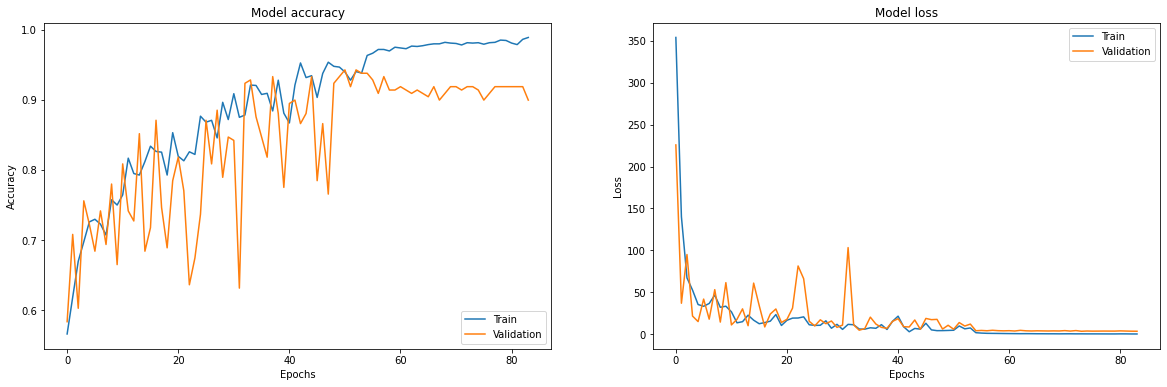

In [14]:
plot_training_history(model.history)

### Export model

In [15]:
model.save()